# Query sentinel API

In [1]:
import pandas as pd
from sentinelhub import SHConfig, BBox, bbox_to_dimensions, SentinelHubRequest, DataCollection, CRS, MimeType
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import cv2

#load dataframe with info at each date and location
predict_images_df = pd.read_csv('../data_predict/deforestation_data.csv')

/Users/eleonoredemarnhac/.pyenv/versions/3.10.6/envs/canopy_watch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_date_range(date_start):
    end_date = date_start + timedelta(days=10)
    return (str(date_start.date()), str(end_date.date()))


def request_sentinel_api(date_start : tuple, date_end : tuple, localisation:list)-> tuple:
    CLIENT_ID = '97202d5b-007e-48a1-8669-7e3e18480ceb'
    CLIENT_SECRET = 'JnWlVNGuv0A1Z1PYV9JzcGS4fDilsRDv'

    config = SHConfig()
    config.sh_client_id = CLIENT_ID
    config.sh_client_secret = CLIENT_SECRET

    evalscript_test = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B04", "B03", "B02"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [3.5 * sample.B04, 3.5 * sample.B03, 3.5 * sample.B02];
    }
    """


    zone_gps = localisation

    start_date = get_date_range(date_start)
    end_date = get_date_range(date_end)
    bbox = BBox(bbox=zone_gps, crs=CRS.WGS84)
    target_size = (256, 256)


    # Définir la requête
    request_start= SentinelHubRequest(
        evalscript = evalscript_test,
        data_folder="satellite_images",
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A,
                time_interval=start_date,
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        bbox=bbox,
        size=target_size,
        config=config,
    )

    request_end = SentinelHubRequest(
        evalscript = evalscript_test,
        data_folder="satellite_images",
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A,
                time_interval=end_date,
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        bbox=bbox,
        size=target_size,
        config=config,
    )

    image_forest_start = request_start.get_data()
    image_forest_start = np.asarray(image_forest_start)[0]

    image_forest_end = request_end.get_data()
    image_forest_end = np.asarray(image_forest_end)[0]

    return image_forest_start,image_forest_end

A runner si besoin

In [3]:
# #Iterate over the dataframe to get a picture at start date and end date for each location
# results = []
# for index, row in predict_images_df.iterrows():
#     start_date = row['start_date']
#     end_date = row['end_date']
#     localisation = row['gps_coordinates']
#     sentinel_images = request_sentinel_api(datetime(start_date, 1, 1),datetime(end_date, 1, 1),localisation)
#     results.append(sentinel_images)

result = request_sentinel_api(datetime(2018, 10, 10),datetime(2022, 11, 1),[10.80994,  5.38464, 10.8174,  5.3915])
result_cameroon = request_sentinel_api(datetime(2018, 10, 10),datetime(2022, 11, 1),[17.49352,8.36484,17.50841,8.38205])

Text(0.5, 1.0, 'image_forest_end')

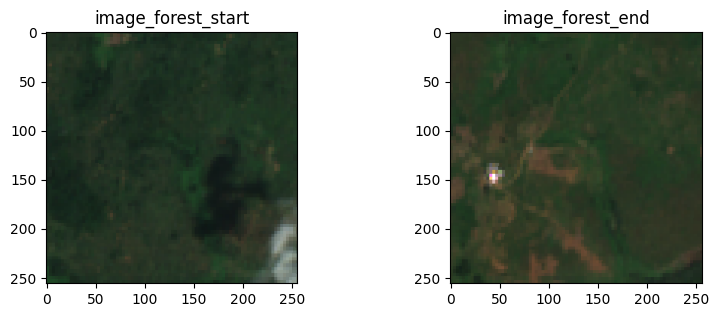

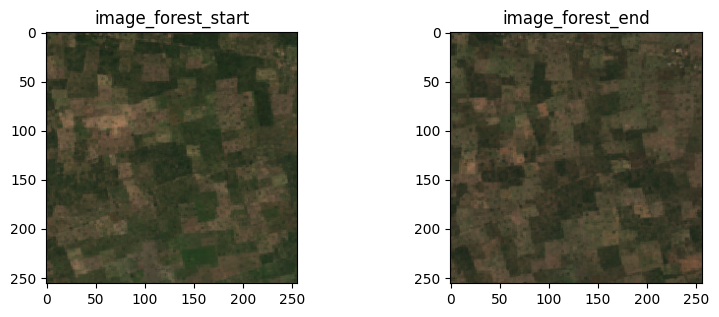

In [4]:
fig = plt.figure(figsize=(20, 15))
plt.subplot(4,4,1)
plt.imshow(result[0])
plt.title('image_forest_start')

plt.subplot(4,4,2)
plt.imshow(result[1])
plt.title('image_forest_end')

fig = plt.figure(figsize=(20, 15))
plt.subplot(4,4,3)
plt.imshow(result_cameroon[0])
plt.title('image_forest_start')

plt.subplot(4,4,4)
plt.imshow(result_cameroon[1])
plt.title('image_forest_end')


 Test with package.py

In [5]:
from canopywatch.sentinel.sentinel_api_request import request_sentinel_api, get_date_range

get_date_range(datetime(2024,10,10))
result = request_sentinel_api(datetime(2018, 10, 10),datetime(2022, 11, 1),[10.80994,  5.38464, 10.81738,  5.3911])

# Load images in data_predict/images

In [6]:
from PIL import Image
im_start = Image.fromarray(result[0])
im_start.save("../data_predict/images/image_start_1.jpeg")

im_end = Image.fromarray(result[0])
im_end.save("../data_predict/images/image_start_1.jpeg")

Test with package.py

In [7]:
from canopywatch.sentinel.sentinel_api_request import request_sentinel_api, get_date_range, load_sentinel_images
from datetime import datetime, timedelta
load_sentinel_images(result_cameroon,2,'cameroon')

# End functions to compare results

In [8]:
from canopywatch.ml_logic.preprocessor import image_preprocessing, image_preprocessing_bulk,mask_preprocessing

def final_results(filepath_mask_start:str, filepath_mask_end:str):
    mask_start = mask_preprocessing(filepath_mask_start)
    mask_end = mask_preprocessing(filepath_mask_end)

    count_forest_start = np.count_nonzero(mask_start==1)
    count_non_forest_start = np.count_nonzero(mask_start==0)
    percentage_forest_start = round(count_forest_start/(count_forest_start+count_non_forest_start) * 100,2)

    count_forest_end = np.count_nonzero(mask_end==1)
    count_non_forest_end = np.count_nonzero(mask_end==0)
    percentage_forest_end = round(count_forest_end/(count_forest_end+count_non_forest_end) * 100,2)

    percentage_evolution = round((count_forest_end - count_forest_start)/count_forest_start*100,2)

    print(f'There was {percentage_forest_start}% of forest in 2018 in the specified zone, {percentage_forest_end}% in 2022, hence a deforestation of {percentage_evolution}% ')
    return percentage_forest_start,percentage_forest_end,percentage_evolution

In [9]:
final_results('../data/forest_segmented/masks/855_mask_01.jpg','../data/forest_segmented/masks/855_mask_02.jpg')

There was 97.88% of forest in 2018 in the specified zone, 4.37% in 2022, hence a deforestation of -95.55% 


(97.88, 4.37, -95.55)

In [10]:
def compare_linear_mask_prediction(predicted_percentage_start:float,predicted_percentage_end:float,filepath_mask_start:str, filepath_mask_end:str):
    percentage_evolution_linear = round((predicted_percentage_end - predicted_percentage_start)/predicted_percentage_start*100,2)
    percentage_evolution_mask = final_results(filepath_mask_start,filepath_mask_end)[2]
    return percentage_evolution_linear,percentage_evolution_mask

In [11]:
predicted_percentage_start = 45
predicted_percentage_end = 29

compare_linear_mask_prediction(predicted_percentage_start,predicted_percentage_end,'../data/forest_segmented/masks/855_mask_01.jpg','../data/forest_segmented/masks/855_mask_02.jpg')

There was 97.88% of forest in 2018 in the specified zone, 4.37% in 2022, hence a deforestation of -95.55% 


(-35.56, -95.55)

# Create df from Google Earth Images

In [12]:
# from canopywatch.ml_logic.preprocessor import image_preprocessing, image_preprocessing_bulk,mask_preprocessing

# test_image_end = image_preprocessing('../data_predict/images/cameroon_test_end_1.jpg')
# test_image_end = cv2.resize(test_image_end, (256, 256))
# test_image_end = test_image_end[:, :, :3]

# #Display picture
# fig = plt.figure(figsize=(15, 10))
# plt.subplot(2,2,1)
# plt.imshow(test_image_end)
# plt.title('image_forest_start')

Text(0.5, 1.0, 'image_forest_start')

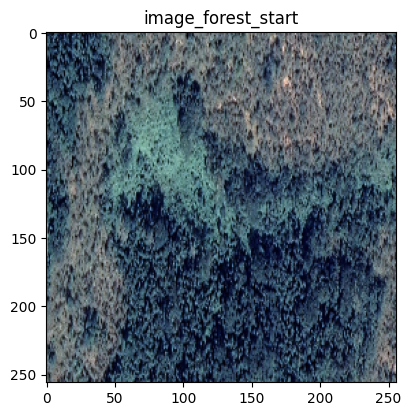

In [ ]:
test_image_start = Image.open('../data_predict/images/cameroon_test_start_1.jpeg')
test_image_start = np.asarray(test_image_start)
test_image_start = cv2.resize(test_image_start, (256, 256))
test_image_start = test_image_start[:, :, :3]

fig = plt.figure(figsize=(15, 10))
plt.subplot(2,2,1)
plt.imshow(test_image_start)
plt.title('image_forest_start')

Text(0.5, 1.0, 'image_forest_end')

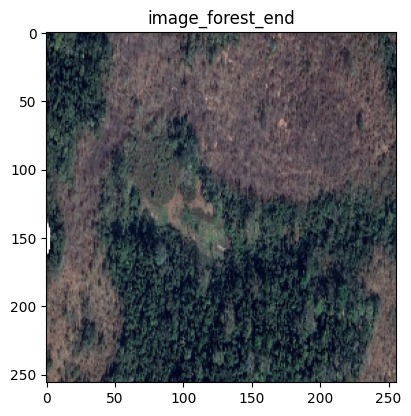

In [48]:
test_image_end = Image.open('../data_predict/images/cameroon_test_end_1.jpeg')
test_image_end = np.asarray(test_image_end)
test_image_end = cv2.resize(test_image_end, (256, 256))  # Resize to 256x256, preserving channels
test_image_end = test_image_end[:, :, :3]

fig = plt.figure(figsize=(15, 10))
plt.subplot(2,2,1)
plt.imshow(test_image_end)
plt.title('image_forest_end')

In [46]:
test_google_earth = (test_image_start,test_image_end)

In [47]:
load_sentinel_images(test_google_earth,3,'cameroon')

[[[ 10  12  48]
  [ 55  74 102]
  [ 14  29  58]
  ...
  [ 74  98 106]
  [100 126 137]
  [ 29  52  59]]

 [[  9  10  44]
  [ 20  40  65]
  [ 14  31  58]
  ...
  [104 127 139]
  [ 84 105 115]
  [ 68  92 103]]

 [[ 10  22  56]
  [ 15  33  61]
  [ 29  46  69]
  ...
  [108 125 139]
  [ 57  74  83]
  [ 21  41  55]]

 ...

 [[116 129 123]
  [ 74  84  84]
  [ 58  61  66]
  ...
  [ 74  93 114]
  [109 128 137]
  [109 113 120]]

 [[145 155 148]
  [ 90  99 100]
  [ 55  60  67]
  ...
  [ 81 104 118]
  [ 97 113 121]
  [125 131 136]]

 [[129 133 127]
  [101 108 110]
  [ 70  75  85]
  ...
  [109 133 144]
  [ 81  95 102]
  [125 129 134]]]


In [54]:
import pandas as pd
import os

folder_path = '/Users/eleonoredemarnhac/Downloads/training_outputs/metrics/'

pickle_files = [f for f in os.listdir(folder_path) if f.endswith('.pickle')]

metrics = []
for pickle_file in pickle_files:

    obj = pd.read_pickle(f'{folder_path}/{pickle_file}')
    metrics.append(obj)
metrics

[{'binary_crossentropy': 0.4563857913017273},
 {'binary_crossentropy': 1.030698299407959},
 {'binary_crossentropy': 0.40955719351768494},
 {'binary_crossentropy': 0.6932248473167419}]

In [ ]:
folder_path = '/Users/eleonoredemarnhac/Documents/google_eath_images'

raw_images = [f for f in os.listdir(folder_path) if f.endswith('.jpeg')]

images = []

for raw_image in raw_images:
    image_start = Image.open(f'{folder_path}/{raw_image}')
    image_start = np.asarray(image_start)
    image_start = cv2.resize(image_start, (256, 256))
    image_start = image_start[:, :, :3]
    images.append(image_start)


In [ ]:
for image
im_start = Image.fromarray(result[0])
im_start.save(f"../data_predict/images/{location}_image_start_{image_number}.jpeg")
im_end = Image.fromarray(result[1])
im_end.save(f"../data_predict/images/{location}_image_end_{image_number}_.jpeg")

(256, 256, 3)

In [66]:
for file_name, array in zip(raw_images, images):
    im = Image.fromarray(array)
    im.save(f"../data_predict/images/{file_name}.jpeg")